In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn import impute
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection

from sklearn.metrics import accuracy_score,roc_curve,auc,precision_recall_curve
from sklearn import model_selection, metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb
import lightgbm as lgb

from scipy import stats

In [9]:
df = pd.read_csv('./bike/NYC-BikeShare.csv')

In [3]:
df.describe()

,Unnamed: 0,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,Trip_Duration_in_min
count,735502.000000,7.355020e+05,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000
mean,10582.401084,9.343125e+02,3206.764183,40.723125,-74.046412,3203.387325,40.722371,-74.045415,24914.009133,1979.544239,1.123668,15.570669
std,7679.871929,4.063878e+04,26.546683,0.008121,0.011191,64.358120,0.095296,0.173044,753.768581,9.371192,0.519694,677.312437
min,0.000000,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,0.000000,-74.096937,14552.000000,1900.000000,0.000000,1.000000
25%,4484.000000,2.460000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24486.000000,1975.000000,1.000000,4.000000
50%,9156.000000,3.830000e+02,3202.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043845,24602.000000,1982.000000,1.000000,6.000000
75%,15003.000000,6.520000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24711.000000,1986.000000,1.000000,11.000000
max,34148.000000,2.026021e+07,3426.000000,40.752559,-74.032108,3442.000000,40.801343,0.000000,29296.000000,2000.000000,2.000000,337670.000000


In [10]:
# move duplicates
df = df.drop_duplicates()

## First look at data

In [5]:
types = df.dtypes
uniques = df.apply(lambda x: [x.unique()])
nulls = df.isna().sum()
counts = df.count()
skewness = df.skew()
kurtosis = df.kurtosis()
distincts = df.apply(lambda x: x.unique().shape[0])

cols = ['types','counts', 'nulls','distincts', 'uniques', 'skewness', 'kurtosis']
pd_cat = pd.concat([types,counts,  nulls,distincts, uniques, skewness, kurtosis], axis = 1)
pd_cat.columns = cols

In [6]:
pd_cat

,types,counts,nulls,distincts,uniques,skewness,kurtosis
Unnamed: 0,int64,339620,0,34149,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0.820649,0.018067
Trip Duration,int64,339620,0,6909,"[[376, 739, 2714, 275, 561, 365, 139, 1299, 64...",337.208608,127024.261710
Start Time,object,339620,0,335561,"[[2015-10-01 00:16:26, 2015-10-01 00:27:12, 20...",NaN,NaN
Stop Time,object,339620,0,335256,"[[2015-10-01 00:22:42, 2015-10-01 00:39:32, 20...",NaN,NaN
Start Station ID,int64,339620,0,51,"[[3212, 3207, 3193, 3199, 3183, 3198, 3206, 31...",1.683038,1.833008
Start Station Name,object,339620,0,51,"[[Christ Hospital, Oakland Ave, Lincoln Park, ...",NaN,NaN
Start Station Latitude,float64,339620,0,51,"[[40.734785818, 40.7376037, 40.7246050998869, ...",0.918977,1.407444
Start Station Longitude,float64,339620,0,51,"[[-74.050443636, -74.05247829999998, -74.07840...",-0.989826,0.847622
End Station ID,int64,339620,0,114,"[[3207, 3212, 3193, 3187, 3192, 3215, 3195, 31...",-37.890013,1746.432885
End Station Name,object,339620,0,114,"[[Oakland Ave, Christ Hospital, Lincoln Park, ...",NaN,NaN


## Outlier detect and clean

1. Trip Duration

In [7]:
df = df[np.abs(stats.zscore(df['Trip Duration']))<3]

In [11]:
q_hi = df['Trip Duration'].quantile(0.99)

In [15]:
IQR = df['Trip Duration'].quantile(0.75) - df['Trip Duration'].quantile(0.25)

In [16]:
q_hi = df['Trip Duration'].quantile(0.75) + 1.5*IQR
q_lo = df['Trip Duration'].quantile(0.25) - 1.5*IQR

In [17]:
q_hi,q_lo

(1269.5, -366.5)

In [18]:
df = df[df['Trip Duration']<q_hi]

E:\Anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Trip Duration'>

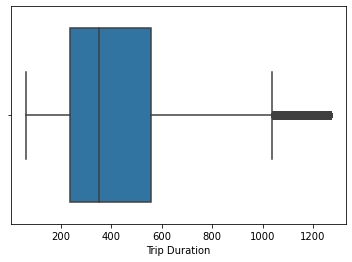

In [20]:
sns.boxplot(df['Trip Duration'])

<AxesSubplot:xlabel='Trip Duration', ylabel='Count'>

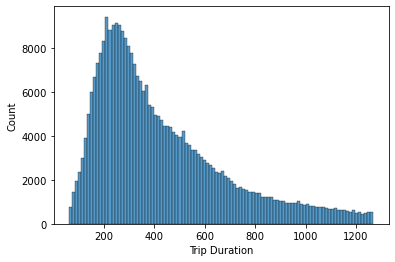

In [19]:
sns.histplot(df, x='Trip Duration',bins=100)

<AxesSubplot:>

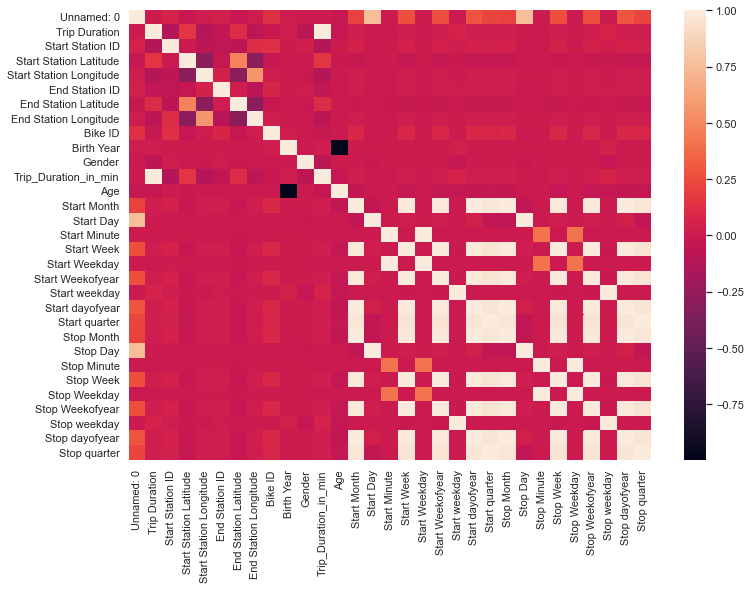

In [218]:
sns.heatmap(df.corr())

### Start station name

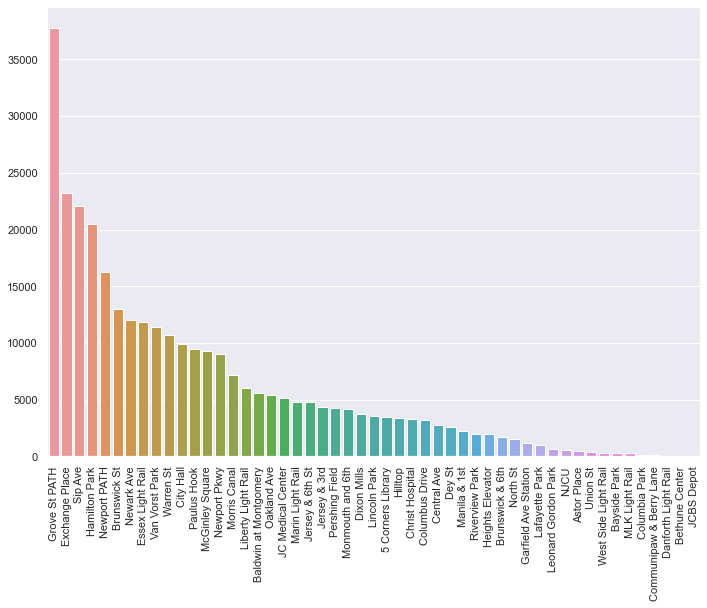

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
barplot = sns.barplot(x=df["Start Station Name"].value_counts().index,
       y=df["Start Station Name"].value_counts().values)

for item in barplot.get_xticklabels():
    item.set_rotation(90)

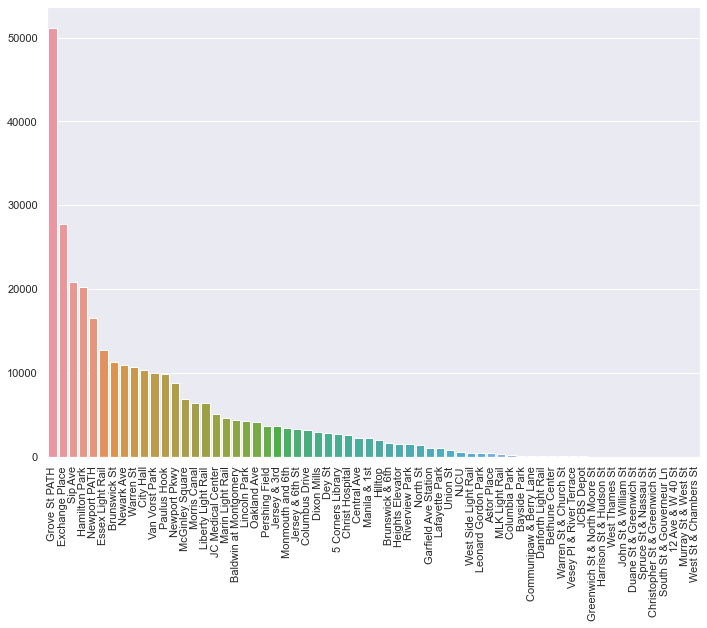

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
barplot = sns.barplot(x=df["End Station Name"].value_counts().index,
       y=df["End Station Name"].value_counts().values)

for item in barplot.get_xticklabels():
    item.set_rotation(90)

### Age

In [54]:
df['Age'] = pd.to_datetime(df['Start Time']).dt.year - df['Birth Year']

<AxesSubplot:xlabel='Age', ylabel='Count'>

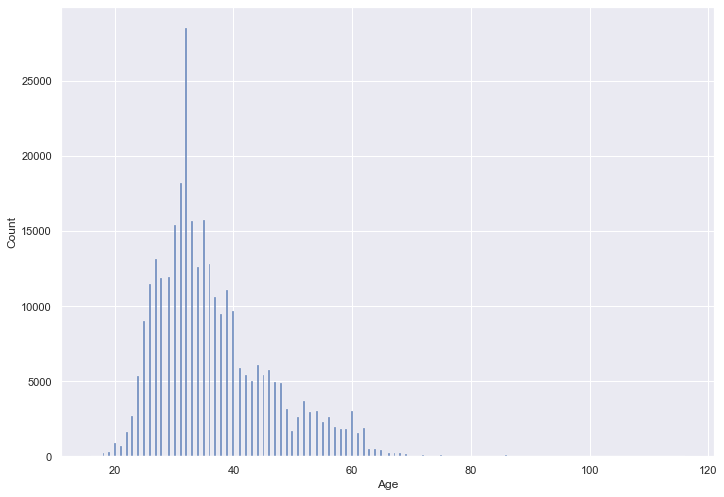

In [56]:
sns.histplot(df, x='Age')

### DateTime

In [92]:
df['Start Date'] = pd.to_datetime(df['Start Time'])
df['Stop Date'] = pd.to_datetime(df['Stop Time'])

In [95]:
df['Start Month'] = df['Start Date'].dt.month
df['Start Day'] =   df['Start Date'].dt.day
df['Start Minute'] = df['Start Date'].dt.minute
df['Start Week'] = df['Start Date'].dt.minute
df['Start Weekday'] = df['Start Date'].dt.minute
df['Start Week'] = df['Start Date'].dt.week
df['Start Weekofyear'] = df['Start Date'].dt.weekofyear
df['Start weekday'] = df['Start Date'].dt.weekday
df['Start dayofyear'] = df['Start Date'].dt.dayofyear
df['Start quarter'] = df['Start Date'].dt.quarter
df['Stop Month'] = df['Stop Date'].dt.month
df['Stop Day'] = df['Start Date'].dt.day
df['Stop Minute'] = df['Stop Date'].dt.minute
df['Stop Week'] = df['Stop Date'].dt.minute
df['Stop Weekday'] = df['Stop Date'].dt.minute
df['Stop Week'] = df['Stop Date'].dt.week
df['Stop Weekofyear'] = df['Stop Date'].dt.weekofyear
df['Stop weekday'] = df['Stop Date'].dt.weekday
df['Stop dayofyear'] = df['Stop Date'].dt.dayofyear
df['Stop quarter'] = df['Stop Date'].dt.quarter

In [97]:
df.columns

Index(['Unnamed: 0', 'Trip Duration', 'Start Time', 'Stop Time',
       'Start Station ID', 'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender', 'Trip_Duration_in_min', 'Age', 'Start Date',
       'Stop Date', 'Start Month', 'Start Day', 'Start Minute', 'Start Week',
       'Start Weekday', 'Start Weekofyear', 'Start weekday', 'Start dayofyear',
       'Start quarter', 'Stop Month', 'Stop Day', 'Stop Minute', 'Stop Week',
       'Stop Weekday', 'Stop Weekofyear', 'Stop weekday', 'Stop dayofyear',
       'Stop quarter'],
      dtype='object')

In [102]:
LabelEncoder().fit_transform(df["Start Station Name"])

array([ 8, 42, 40, ..., 21, 19, 16])

In [104]:
ndf = df[['Trip Duration', 'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'User Type',
       'Trip_Duration_in_min', 'Age', 'Start Month', 'Start Day', 'Start Minute', 'Start Week',
       'Start Weekday', 'Start Weekofyear', 'Start weekday', 'Start dayofyear',
       'Start quarter', 'Stop Month', 'Stop Day', 'Stop Minute', 'Stop Week',
       'Stop Weekday', 'Stop Weekofyear', 'Stop weekday', 'Stop dayofyear',
       'Stop quarter','Gender']]

### Gender

In [58]:
df['Gender'].value_counts()

1    227201
2     64278
0     17550
Name: Gender, dtype: int64

<AxesSubplot:>

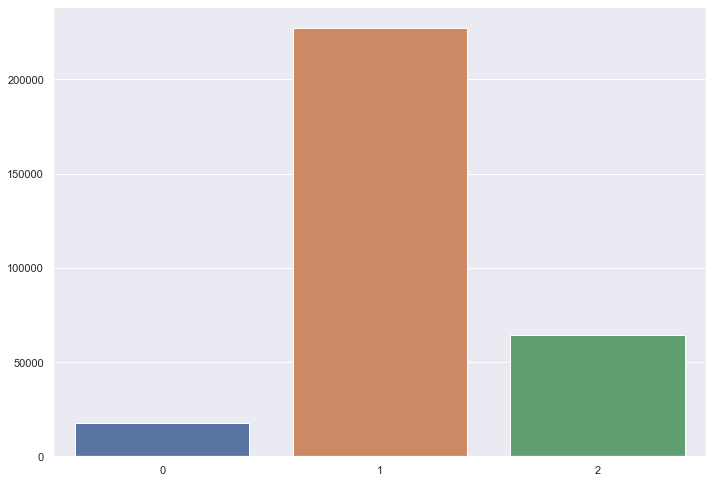

In [59]:
sns.barplot(x=df['Gender'].value_counts().index, y=df['Gender'].value_counts().values)

## Modelling

In [113]:
ndf = ndf[ndf['Gender']!=0]

In [134]:
ndf[['Start Station Name', 'End Station Name','User Type']]=ndf[['Start Station Name', 'End Station Name','User Type']].apply(LabelEncoder().fit_transform)

E:\Anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [135]:
ndf

,Trip Duration,Start Station Name,Start Station Latitude,Start Station Longitude,End Station Name,End Station Latitude,End Station Longitude,User Type,Trip_Duration_in_min,Age,...,Stop Month,Stop Day,Stop Minute,Stop Week,Stop Weekday,Stop Weekofyear,Stop weekday,Stop dayofyear,Stop quarter,Gender
0,376,8,40.734786,-74.050444,48,40.737604,-74.052478,1,6,55.0,...,10,1,22,40,22,40,3,274,4,1
1,739,42,40.737604,-74.052478,9,40.734786,-74.050444,1,12,55.0,...,10,1,39,40,39,40,3,274,4,1
3,275,40,40.728745,-74.032108,58,40.721124,-74.038051,1,5,40.0,...,10,1,39,40,39,40,3,274,4,1
6,139,22,40.731169,-74.057574,52,40.730743,-74.063784,1,2,27.0,...,10,1,46,40,46,40,3,274,4,1
8,647,48,40.718489,-74.047727,21,40.710467,-74.070039,1,11,27.0,...,10,1,12,40,12,40,3,274,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378141,589,18,40.710467,-74.070039,23,40.719586,-74.043117,1,10,27.0,...,9,30,27,40,27,40,2,273,3,1
378142,383,20,40.727596,-74.044247,58,40.721124,-74.038051,1,6,52.0,...,9,30,27,40,27,40,2,273,3,1
378143,717,48,40.718489,-74.047727,36,40.711131,-74.078885,1,12,29.0,...,9,30,39,40,39,40,2,273,3,1
378145,237,19,40.719586,-74.043117,56,40.718489,-74.047727,1,4,33.0,...,9,30,41,40,41,40,2,273,3,2


In [136]:
train, test = train_test_split(ndf, train_size = 0.8, test_size = 0.2)

In [142]:
x_train, y_train = train.drop(['Gender'],axis=1), train.Gender
x_test, y_test = test.drop(['Gender'],axis=1), test.Gender

### Random Forest

In [138]:
rf = RandomForestClassifier(n_estimators=100)

In [139]:
rf.fit(x_train, y_train)

RandomForestClassifier()

In [183]:
rf_pred = rf.predict_proba(x_test)

In [185]:
fpr_Nb, tpr_Nb, _ = roc_curve(y_test, rf_pred[:,1], pos_label=2)
aucval = auc(fpr_Nb, tpr_Nb)
print("area under ROC score:", aucval)

area under ROC score: 0.8446676109659594


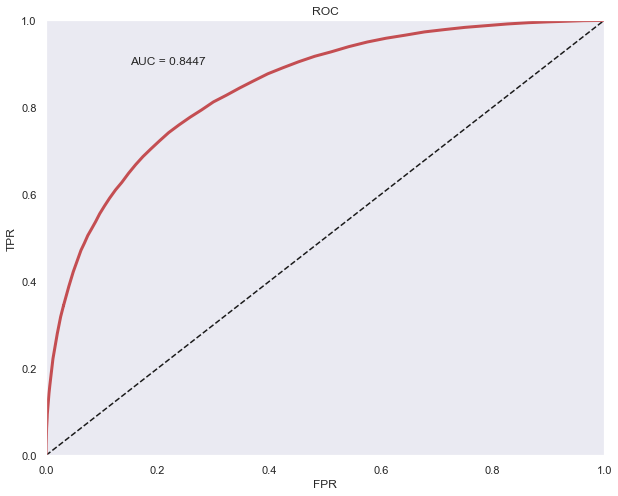

In [186]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
plt.show()

In [190]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_pred[:,1], pos_label=2)
aucprc = auc(recall, precision)
print("area under PRC score:", aucprc)

area under PRC score: 0.6450267250924869


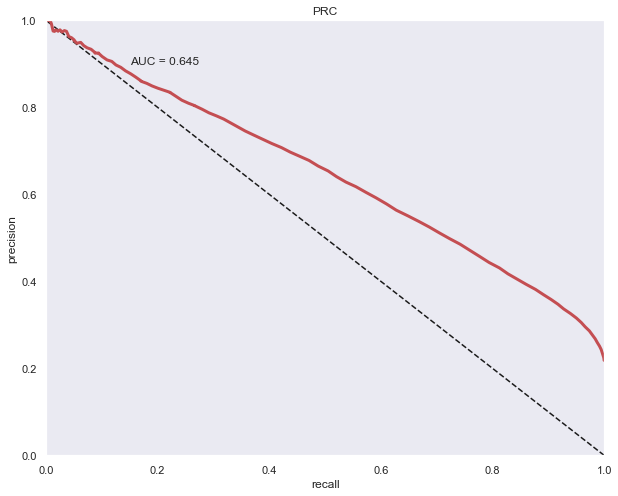

In [193]:
plt.figure(figsize=(10,8))
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(recall, precision,"r",linewidth = 3)
plt.grid()
plt.xlabel("recall")
plt.ylabel("precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("PRC")
plt.text(0.15,0.9,"AUC = "+str(round(aucprc,4)))
plt.show()

In [196]:
#check feature importance
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': train.drop(['Gender'],axis=1).columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

                    Feature  Importance
9                       Age    0.125810
0             Trip Duration    0.091675
12             Start Minute    0.048812
14            Start Weekday    0.048759
23             Stop Weekday    0.048515
21              Stop Minute    0.048407
3   Start Station Longitude    0.041540
17          Start dayofyear    0.041524
26           Stop dayofyear    0.041450
2    Start Station Latitude    0.040671
6     End Station Longitude    0.039560
5      End Station Latitude    0.037577
11                Start Day    0.037432
20                 Stop Day    0.037265
1        Start Station Name    0.037092
4          End Station Name    0.036408
8      Trip_Duration_in_min    0.035240
25             Stop weekday    0.024838
16            Start weekday    0.024830
15         Start Weekofyear    0.022481
24          Stop Weekofyear    0.022356
22                Stop Week    0.022160
13               Start Week    0.022125
19               Stop Month    0.008821


In [197]:
num_features = 16  # Choose an appropriate number based on your experimentation
selected_features = feature_importance_df.nlargest(num_features, 'Importance')['Feature'].values

# Create a new DataFrame with only the feature you have selected
ndf_top = ndf[selected_features]
print(selected_features)

['Age' 'Trip Duration' 'Start Minute' 'Start Weekday' 'Stop Weekday'
 'Stop Minute' 'Start Station Longitude' 'Start dayofyear'
 'Stop dayofyear' 'Start Station Latitude' 'End Station Longitude'
 'End Station Latitude' 'Start Day' 'Stop Day' 'Start Station Name'
 'End Station Name']


## Grid Search

In [204]:
x_train = train[selected_features]
x_test = test[selected_features]

In [209]:
rfc = RandomForestClassifier()
param_grid = {
    'bootstrap': [True],
    #'max_depth': [80, 90, 100, 110],
    #'max_features': [2, 3],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    #'n_estimators': [100, 200, 300, 1000]
}
grid_rf = GridSearchCV(rfc, param_grid=param_grid, scoring='accuracy', cv=5)

In [210]:
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True]}, scoring='accuracy')

In [221]:
grid_rf.best_params_

{'bootstrap': True}

In [216]:
rfc_pred = grid_rf.best_estimator_.predict_proba(x_test)

In [217]:
precision, recall, thresholds = precision_recall_curve(y_test, rfc_pred[:,1], pos_label=2)
aucprc = auc(recall, precision)
print("area under PRC score:", aucprc)

area under PRC score: 0.7047671673344846
